In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mfpml.problems.multifidelity_functions import *
from scipy.stats import spearmanr
from mfpml.design_of_experiment import MFSobolSequence

In [2]:
# calculate the correlation of each function
problem_sets = [
    "mf_Bohachevsky",
    "mf_Booth",
    "mf_Borehole",
    "mf_CurrinExp",
    "mf_Hartman3",
    "mf_Hartman6",
    "mf_Himmelblau",
    "mf_Park91A",
    "mf_Park91B",
    "mf_Sixhump",
]
# create an array to store the correlation
correlation_array = pd.DataFrame(
    np.zeros((len(problem_sets), 3)), columns=["function", "correlation", "dimension"]
)
for name in problem_sets:
    func = eval(name)()
    # get samplers
    sampler = MFSobolSequence(design_space=func.design_space, nested=True)
    # sample the function
    samples = sampler.get_samples(num_lf_samples=1000, num_hf_samples=1000)
    responses = func(samples)
    # calculate the correlation
    r2 = spearmanr(responses["hf"], responses["lf"])
    # save the correlation
    correlation_array.loc[problem_sets.index(name), "function"] = name
    correlation_array.loc[problem_sets.index(
        name), "correlation"] = r2.correlation
    correlation_array.loc[problem_sets.index(name), "dimension"] = func.num_dim

    print("=====================================")
    print("Function: ", name)
    print("Correlation: ", r2.correlation)
    print("Dimension: ", func.num_dim)
    print("=====================================")
# print(correlation_array)
correlation_array

Function:  mf_Bohachevsky
Correlation:  0.8942052302052304
Dimension:  2
Function:  mf_Booth
Correlation:  0.8220090780090781
Dimension:  2
Function:  mf_Borehole
Correlation:  0.9999999879999882
Dimension:  8
Function:  mf_CurrinExp
Correlation:  0.9972042492042492
Dimension:  2
Function:  mf_Hartman3
Correlation:  -0.2675776475776476
Dimension:  3
Function:  mf_Hartman6
Correlation:  0.7372856212856214
Dimension:  6
Function:  mf_Himmelblau
Correlation:  0.8230726390726392
Dimension:  2
Function:  mf_Park91A
Correlation:  0.9925255165255166
Dimension:  4
Function:  mf_Park91B
Correlation:  1.0
Dimension:  4
Function:  mf_Sixhump
Correlation:  0.630914994914995
Dimension:  2


,function,correlation,dimension
0,mf_Bohachevsky,0.894205,2.0
1,mf_Booth,0.822009,2.0
2,mf_Borehole,1.000000,8.0
3,mf_CurrinExp,0.997204,2.0
4,mf_Hartman3,-0.267578,3.0
5,mf_Hartman6,0.737286,6.0
6,mf_Himmelblau,0.823073,2.0
7,mf_Park91A,0.992526,4.0
8,mf_Park91B,1.000000,4.0
9,mf_Sixhump,0.630915,2.0


## read results from the file

In this notebook, we will do ablation study about MF-RBF-Kriging model.


In [3]:
# read results for mf-rbf-kriging
mf_rbf_kriging_input = pd.read_csv(
    "../mf_rbf_kriging/exp_mf_rbf_input.csv", index_col=0
)
mf_rbf_kriging_output = pd.read_csv(
    "../mf_rbf_kriging/exp_mf_rbf_output.csv", index_col=0
)
# merge input and output
mf_rbf_kriging_results = pd.merge(
    mf_rbf_kriging_input, mf_rbf_kriging_output, left_index=True, right_index=True
)
# make normalized_mae and normalized_rmse to be absolute value
mf_rbf_kriging_results["normalized_mae"] = mf_rbf_kriging_results[
    "normalized_mae"
].abs()
mf_rbf_kriging_results["normalized_rmse"] = mf_rbf_kriging_results[
    "normalized_rmse"
].abs()


# load kriging results
kriging_input = pd.read_csv("../kriging/exp_kriging_input.csv", index_col=0)
kriging_output = pd.read_csv("../kriging/exp_kriging_output.csv", index_col=0)
# merge input and output
kriging_results = pd.merge(
    kriging_input, kriging_output, left_index=True, right_index=True
)
# make normalized_mae and normalized_rmse to be absolute value
kriging_results["normalized_mae"] = kriging_results["normalized_mae"].abs()
kriging_results["normalized_rmse"] = kriging_results["normalized_rmse"].abs()
# remove results of "Forrestor_1a"
kriging_results = kriging_results[kriging_results["problem"] != "Forrester_1a"]

In [4]:
mf_rbf_kriging_results.problem.unique()

array(['mf_Bohachevsky', 'mf_Booth', 'mf_Borehole', 'mf_CurrinExp',
       'mf_Hartman3', 'mf_Hartman6', 'mf_Himmelblau', 'mf_Park91A',
       'mf_Park91B', 'mf_Sixhump'], dtype=object)

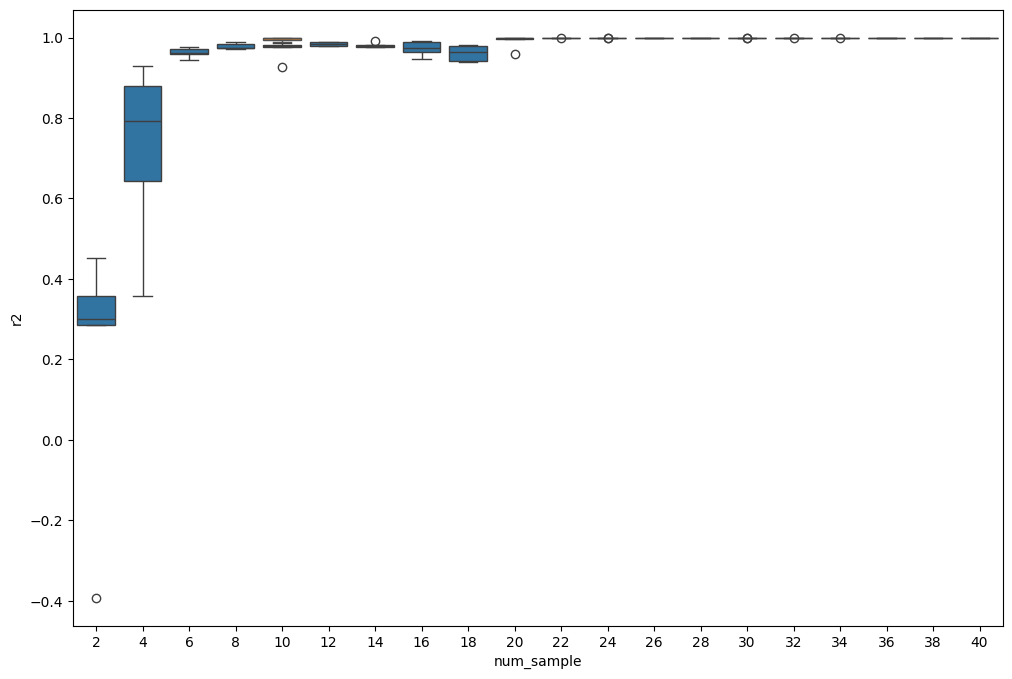

In [7]:
# select mf_Hartman3 function
mf_rbf_kriging_results_hartman3 = mf_rbf_kriging_results[
    mf_rbf_kriging_results["problem"] == "mf_Sixhump"
]
kriging_results_hartman3 = kriging_results[kriging_results["problem"] == "mf_Sixhump"]
# find out the case with 100d lf samples and 10d hf samples
aa = mf_rbf_kriging_results_hartman3[
    (mf_rbf_kriging_results_hartman3["num_lf"] == 100)
    & (mf_rbf_kriging_results_hartman3["num_hf"] == 10)
]
# same plots for normalized_mae and normalized_rmse and r2
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
# plot r2
sns.boxplot(
    x="num_sample",
    y="r2",
    data=kriging_results_hartman3,
)
# # plot results of mf-rbf-kriging
sns.boxplot(
    x="num_hf",
    y="r2",
    data=aa,
)
plt.show()

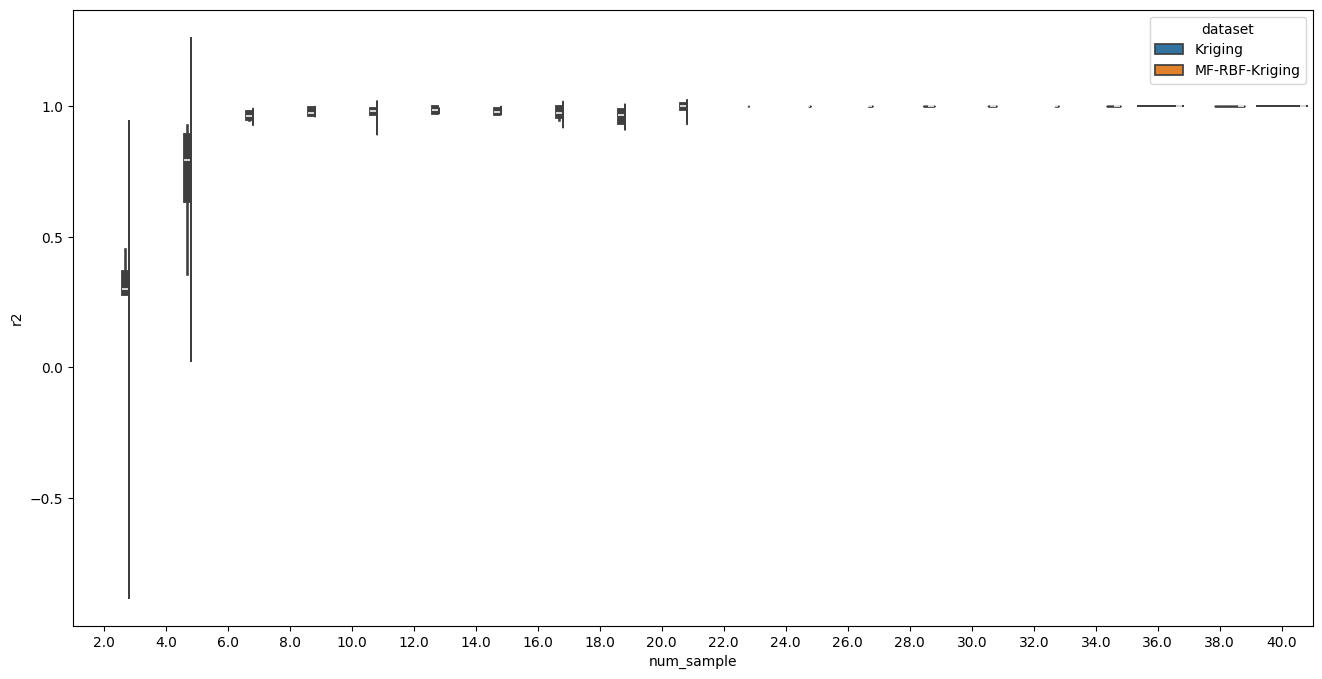

In [10]:
# Combine the datasets
combined_data = pd.concat(
    [
        kriging_results_hartman3.assign(dataset="Kriging"),
        aa.assign(dataset="MF-RBF-Kriging"),
    ]
)

# Create a violin plot with hue
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
sns.violinplot(
    x="num_sample", y="r2", hue="dataset", data=combined_data, ax=ax, split=True
)
plt.show()